# Fixing the other tables
This notebooks continues the work done in <a href="books_10k_exploration.ipynb">books_10k_exploration.ipynb</a>.

In that notebook, I selected books which will be used in that project. 

Now, I need to remove the relationships with the books that were not selected and prepare the tables used in the population of the database.
## Setup

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
# Set a seed for reproducibility
np.random.seed(0)
data_folder = Path.cwd().parent / 'data'
transformed_folder = data_folder / 'transformed'

ratings = pd.read_csv( Path(data_folder / 'ratings.csv' ) )
to_read = pd.read_csv( Path(data_folder / 'to_read.csv' ) )
usernames = pd.read_csv( Path(data_folder / 'users_reddit.csv' ) )
books = pd.read_csv( Path(transformed_folder / 'books_expanded.csv' ) )
book_embeddings= pd.read_csv( Path(transformed_folder / 'book_embeddings.csv' ) )

## Fix the other tables

In [2]:
books.head()

book_id                                                url  \
0        1  https://www.goodreads.com/book/show/2767052-th...   
1        3  https://www.goodreads.com/book/show/41865.Twil...   
2        8  https://www.goodreads.com/book/show/5107.The_C...   
3        9  https://www.goodreads.com/book/show/960.Angels...   
4       12  https://www.goodreads.com/book/show/13335037-d...   

                    title        isbn  \
0        The Hunger Games  0439023483   
1                Twilight  0316015849   
2  The Catcher in the Rye  0316769177   
3         Angels & Demons  1416524797   
4               Divergent  0062024035   

                                         description  \
0  Could you survive on your own in the wild, wit...   
1  About three things I was absolutely positive.F...   
2  It's Christmas time and Holden Caulfield has j...   
3  World-renowned Harvard symbologist Robert Lang...   
4  In Beatrice Prior's dystopian Chicago world, s...   

                                            imageUrl  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                              genres  \
0  ['Dystopia', 'Romance', 'Young Adult', 'Audiob...   
1  ['Romance', 'Supernatural', 'Paranormal Romanc...   
2  ['American', 'Coming Of Age', 'Read For School...   
3  ['Thriller', 'Mystery', 'Mystery Thriller', 'N...   
4  ['Dystopia', 'Romance', 'Young Adult', 'Fictio...   

                   publisher               author publishDate  \
0           Scholastic Press  ['Suzanne Collins']  2008-10-14   
1  Little, Brown and Company  ['Stephenie Meyer']  2006-09-06   
2             Back Bay Books    ['J.D. Salinger']  2001-01-30   
3               Pocket Books        ['Dan Brown']  2006-04-01   
4      Katherine Tegen Books    ['Veronica Roth']  2012-01-01   

   goodreads_book_id language  
0            2767052  English  
1              41865  English  
2               5107  English  
3                960  English  
4           13335037  English

### Fix the to_read dataframe

Remove book_id which we dont have anymore

In [3]:
book_ids=books.book_id.tolist()
to_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912705 entries, 0 to 912704
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  912705 non-null  int64
 1   book_id  912705 non-null  int64
dtypes: int64(2)
memory usage: 13.9 MB


In [4]:
to_read_filtered = to_read[to_read['book_id'].isin(book_ids)].reset_index(drop=True)
to_read_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569422 entries, 0 to 569421
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  569422 non-null  int64
 1   book_id  569422 non-null  int64
dtypes: int64(2)
memory usage: 8.7 MB


### Fix the ratings dataframe

Remove book_ids which we dont have anymore

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [6]:
ratings_filtered = ratings[ratings['book_id'].isin(book_ids)].reset_index(drop=True)
ratings_filtered.head()

user_id  book_id  rating
0        2     2318       3
1        2      315       3
2        2       33       4
3        2      301       5
4        2     2686       5

### Creating a users dataframe

Regarding users, in this dataset we only have the user_ids.

I want my users to have a username as well, also sex.

I'm going to join the user_ids with a dataset of reddit usernames. and assign sex randomly.

In [7]:
users=pd.concat([ratings.user_id,to_read.user_id]).drop_duplicates().sort_values().reset_index(drop=True).values
len_user=len(users)
usernames.head()


author   n
0          Lee4an  46
1  Partypooper009  80
2       Jenna1021  41
3      ALMEHZA_02   1
4     Fakehashish  32

In [8]:
users=pd.DataFrame({"user_id":users, "username":usernames.author.unique()[:len_user]})
users.head()

user_id        username
0        1          Lee4an
1        2  Partypooper009
2        3       Jenna1021
3        4      ALMEHZA_02
4        5     Fakehashish

In [9]:

# Assign 'male' or 'female' randomly to the 'sex' column
users['sex'] = np.random.choice(['male', 'female'], size=len(users))
users.to_csv(Path(transformed_folder,"users.csv"), index=False)
users.head()

user_id        username     sex
0        1          Lee4an    male
1        2  Partypooper009  female
2        3       Jenna1021  female
3        4      ALMEHZA_02    male
4        5     Fakehashish  female

In [10]:
len(users.username.unique())==len(users)

True

In [11]:
len(users)

53424

### Reviews per users
See how many reviews each user has made

In [12]:
reviews_per_user = ratings_filtered.groupby( 'user_id' ).user_id.apply( lambda x: len( x ))
reviews_per_user.describe()

count    53424.000000
mean        70.231263
std         20.989399
min          1.000000
25%         57.000000
50%         70.000000
75%         83.000000
max        155.000000
Name: user_id, dtype: float64

<Axes: xlabel='user_id'>

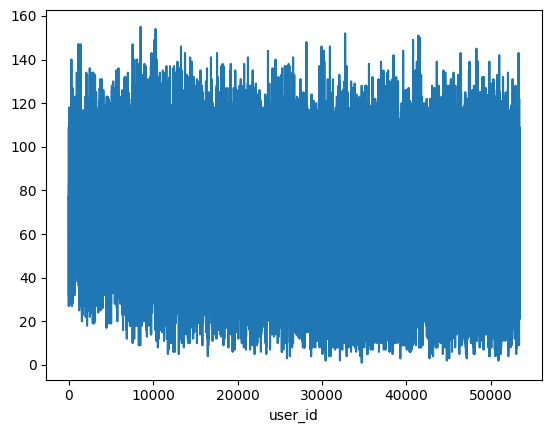

In [13]:
reviews_per_user.plot()

Conclusion: Every user in our dataset has given at least one review

### Split the genres and authors

Right now, genres and author can have multiple values, but it's still all one string. Transform genres to lists.

In [14]:
books["genres_list"]=books.genres.apply(lambda x: list(map(lambda x: x.strip().strip("'"),x.strip("[").strip("]").split(","))))
books["author_list"]=books.author.apply(lambda x: list(map(lambda x: x.strip().strip("'"),x.strip("[").strip("]").split(","))))

books.head(3)

book_id                                                url  \
0        1  https://www.goodreads.com/book/show/2767052-th...   
1        3  https://www.goodreads.com/book/show/41865.Twil...   
2        8  https://www.goodreads.com/book/show/5107.The_C...   

                    title        isbn  \
0        The Hunger Games  0439023483   
1                Twilight  0316015849   
2  The Catcher in the Rye  0316769177   

                                         description  \
0  Could you survive on your own in the wild, wit...   
1  About three things I was absolutely positive.F...   
2  It's Christmas time and Holden Caulfield has j...   

                                            imageUrl  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   

                                              genres  \
0  ['Dystopia', 'Romance', 'Young Adult', 'Audiob...   
1  ['Romance', 'Supernatural', 'Paranormal Romanc...   
2  ['American', 'Coming Of Age', 'Read For School...   

                   publisher               author publishDate  \
0           Scholastic Press  ['Suzanne Collins']  2008-10-14   
1  Little, Brown and Company  ['Stephenie Meyer']  2006-09-06   
2             Back Bay Books    ['J.D. Salinger']  2001-01-30   

   goodreads_book_id language  \
0            2767052  English   
1              41865  English   
2               5107  English   

                                         genres_list        author_list  
0  [Dystopia, Romance, Young Adult, Audiobook, Fi...  [Suzanne Collins]  
1  [Romance, Supernatural, Paranormal Romance, Pa...  [Stephenie Meyer]  
2  [American, Coming Of Age, Read For School, Cla...    [J.D. Salinger]

In [15]:
books["author_list"][0][0]

'Suzanne Collins'

## Join this dataframe with the one with embeddings

In [19]:
old_columns=list(books.columns)
new_columns=old_columns+["embedding"]
joined = pd.merge(books, book_embeddings, on='book_id', how='inner')
#rename isbn_x to isbn
joined = joined.rename(columns={'isbn_x': 'isbn'})
#rename embeddings to embedding
joined = joined.rename(columns={'embeddings': 'embedding'})
books_with_embeddings=joined.loc[:,new_columns]


Save this version of books

In [20]:
books_with_embeddings.to_csv(Path(transformed_folder,"books_final.csv"), index=False)

### Make a genre dataframe

Find unique genres

In [27]:
genres=books.genres_list.explode().unique()
genres=pd.DataFrame({"genre_id":np.arange(len(genres))+1,"genre":genres})
genres.head()


genre_id        genre
0         1     Dystopia
1         2      Romance
2         3  Young Adult
3         4    Audiobook
4         5      Fiction

In [28]:
indices=books.genres_list.explode().index
indices


Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       ...
       4741, 4741, 4741, 4741, 4741, 4741, 4741, 4741, 4741, 4741],
      dtype='int64', length=47404)

In [29]:
book_ids_per_index=books.book_id.iloc[indices]
book_ids_per_index

0          1
0          1
0          1
0          1
0          1
        ... 
4741    9478
4741    9478
4741    9478
4741    9478
4741    9478
Name: book_id, Length: 47404, dtype: int64

In [30]:
genre_to_id_dict={li[1]:li[0] for li in list(map(lambda x: list(x.values()),genres.to_dict("records")))}
genre_to_id_dict

{'Dystopia': 1,
 'Romance': 2,
 'Young Adult': 3,
 'Audiobook': 4,
 'Fiction': 5,
 'Post Apocalyptic': 6,
 'Teen': 7,
 'Adventure': 8,
 'Fantasy': 9,
 'Science Fiction': 10,
 'Supernatural': 11,
 'Paranormal Romance': 12,
 'Paranormal': 13,
 'Urban Fantasy': 14,
 'Vampires': 15,
 'American': 16,
 'Coming Of Age': 17,
 'Read For School': 18,
 'Classics': 19,
 'Novels': 20,
 'Literature': 21,
 'School': 22,
 'High School': 23,
 'Thriller': 24,
 'Mystery': 25,
 'Mystery Thriller': 26,
 'Historical Fiction': 27,
 'Suspense': 28,
 'Adult': 29,
 'Crime': 30,
 'Action': 31,
 'Adult Fiction': 32,
 'Sweden': 33,
 'Contemporary': 34,
 'Middle Grade': 35,
 'Witches': 36,
 'Science Fiction Fantasy': 37,
 'Childrens': 38,
 'High Fantasy': 39,
 'Epic Fantasy': 40,
 'Book Club': 41,
 'Historical': 42,
 'Chick Lit': 43,
 'Japan': 44,
 'Asia': 45,
 'BDSM': 46,
 'Erotica': 47,
 'Erotic Romance': 48,
 'Contemporary Romance': 49,
 'Philosophy': 50,
 'Self Help': 51,
 'Spirituality': 52,
 'Dragons': 53,
 '

In [31]:
genres_expanded=books.genres_list.explode().values
genres_expanded

array(['Dystopia', 'Romance', 'Young Adult', ..., 'Humor', 'Self Help',
       'Taoism'], dtype=object)

In [32]:
genres_expanded_to_ids=list(map(lambda x: genre_to_id_dict[x],genres_expanded))
genres_expanded_to_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 2,
 11,
 12,
 13,
 3,
 5,
 14,
 7,
 15,
 9,
 16,
 17,
 18,
 19,
 20,
 3,
 5,
 21,
 22,
 23,
 24,
 25,
 26,
 20,
 27,
 5,
 28,
 29,
 8,
 30,
 1,
 2,
 3,
 5,
 6,
 7,
 8,
 31,
 9,
 10,
 24,
 32,
 33,
 26,
 25,
 34,
 5,
 28,
 29,
 30,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 35,
 36,
 20,
 3,
 4,
 14,
 8,
 37,
 9,
 38,
 39,
 40,
 19,
 20,
 4,
 3,
 5,
 8,
 37,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 24,
 32,
 25,
 26,
 3,
 34,
 5,
 29,
 9,
 30,
 1,
 18,
 19,
 20,
 3,
 5,
 21,
 8,
 22,
 23,
 32,
 41,
 19,
 4,
 34,
 27,
 5,
 29,
 42,
 43,
 16,
 18,
 19,
 20,
 27,
 5,
 42,
 21,
 22,
 23,
 32,
 2,
 19,
 20,
 27,
 5,
 42,
 44,
 29,
 45,
 32,
 2,
 46,
 47,
 48,
 34,
 43,
 5,
 29,
 49,
 50,
 51,
 19,
 20,
 52,
 4,
 5,
 21,
 8,
 9,
 1,
 38,
 18,
 35,
 19,
 3,
 5,
 22,
 9,
 10,
 39,
 53,
 40,
 20,
 4,
 5,
 29,
 8,
 37,
 9,
 54,
 2,
 55,
 56,
 52,
 43,
 34,
 57,
 58,
 59,
 2,
 19,
 60,
 20,
 61,
 27,
 5,
 42,
 21,
 22,
 62,
 50,
 19,
 20,
 63,
 64,
 5,

In [33]:
books_genres=pd.DataFrame({"book_id":book_ids_per_index.values, "genre_id":genres_expanded_to_ids})
books_genres.head()

book_id  genre_id
0        1         1
1        1         2
2        1         3
3        1         4
4        1         5

In [34]:
len(books_genres)==len(books.genres_list.explode())

True

In [35]:
len(books_genres)==len(books_genres.drop_duplicates())

True

save new dataframes

In [36]:
genres.to_csv(Path(transformed_folder,"genres.csv"),index=False)
books_genres.to_csv(Path(transformed_folder,"books_genres.csv"),index=False)

### Create a read books dataframe

My goal is to create a dataframe which will look like ratings_filtered, but for some books, the rating will be 0, meaning that the book was read, but unrated.

How many books to mark as unread, I will choose randomly for each user, between 0 and 10.

In [37]:
ratings_filtered.head()

user_id  book_id  rating
0        2     2318       3
1        2      315       3
2        2       33       4
3        2      301       5
4        2     2686       5

<Axes: >

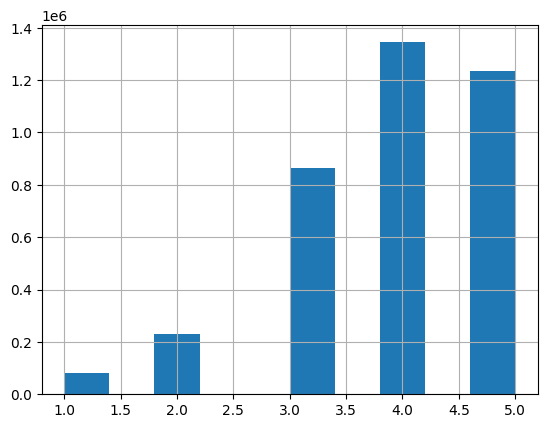

In [38]:
ratings_filtered.rating.hist(bins=10)

In [39]:
# Function to apply to each group of user_id to set a random number of ratings to 0
def set_random_ratings_zero(df):
    n = np.random.randint(0, 11)  # random number between 0 and 10
    ratings_to_zero = df.sample(n=min(n, len(df)))  # select n or the length of df, whichever is smaller
    df.loc[ratings_to_zero.index, 'rating'] = 0  # set the selected ratings to zero
    return df

# Applying the function to each group of user_id
read_books_df = ratings_filtered.groupby('user_id').apply(set_random_ratings_zero).reset_index(drop=True)

# Displaying the new dataframe
read_books_df.head()

C:\Users\Eleonora\AppData\Local\Temp\ipykernel_13316\856540056.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  read_books_df = ratings_filtered.groupby('user_id').apply(set_random_ratings_zero).reset_index(drop=True)


user_id  book_id  rating
0        1     5556       3
1        1     3638       3
2        1     1796       5
3        1      867       3
4        1     2738       0

In the evaluation, I don't want to access the database, so I won't have book_ids and user_ids generated by the database.

For that reason, I want to have the relationship between user_id and book_id in the dataframe, not just usernames and isbns.

In [40]:
# Merge on user_id to get usernames
read_books_df_help = read_books_df.merge(users, left_on='user_id', right_on='user_id')
read_books_df_help=read_books_df_help.loc[:,['username','book_id','rating', "user_id"]]
read_books_df_help.head()

username  book_id  rating  user_id
0   Lee4an     5556       3        1
1   Lee4an     3638       3        1
2   Lee4an     1796       5        1
3   Lee4an      867       3        1
4   Lee4an     2738       0        1

In [41]:
#Merge on book_id to get isbn
read_books_df_help = read_books_df_help.merge(books, left_on='book_id', right_on='book_id')
read_books_df_help=read_books_df_help.loc[:,['username','isbn','rating','user_id','book_id']]
read_books_df_help.head()

username        isbn  rating  user_id  book_id
0   Lee4an  1400097029       3        1     5556
1   Lee4an  0312424094       3        1     3638
2   Lee4an  031242440X       5        1     1796
3   Lee4an  0393328627       3        1      867
4   Lee4an  0385722206       0        1     2738

<Axes: >

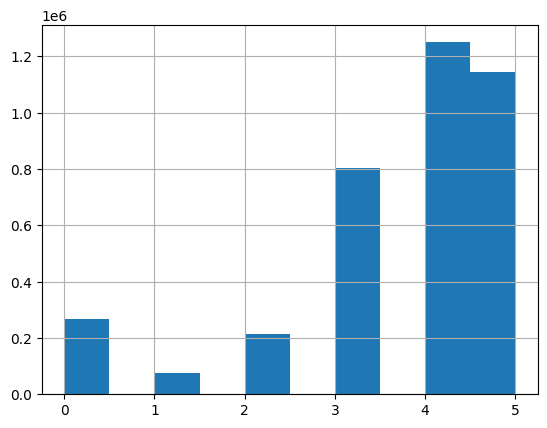

In [42]:
read_books_df.rating.hist(bins=10)

In [43]:
read_books_df_help.to_csv(Path(transformed_folder,"ratings_filtered_some_set_to_0.csv"), index=False)

### Change to_read_filtered

Replace user_id with username and book_id with isbn

In [44]:
to_read_filtered.head()

user_id  book_id
0        9        8
1       15      398
2       15      275
3       37     7173
4       34      380

In [45]:
#replace user_id with username
to_read_df_help= to_read_filtered.merge(users, left_on='user_id', right_on='user_id')
to_read_df_help=to_read_df_help.loc[:,['username','book_id']]
to_read_df_help.head()

username  book_id
0  theblacktaco        8
1         Xsxcx      398
2         Xsxcx      275
3        neetro     7173
4   ablogotrip9      380

In [46]:
#replace book_id with isbn
to_read_df_help= to_read_df_help.merge(books, left_on='book_id', right_on='book_id')
to_read_df_help=to_read_df_help.loc[:,['username','isbn']]
to_read_df_help.head()

username        isbn
0  theblacktaco  0316769177
1         Xsxcx  0060838582
2         Xsxcx  0525476881
3        neetro  4770019572
4   ablogotrip9  0375704027

In [47]:
#save to csv
to_read_df_help.to_csv(Path(transformed_folder,"to_read_filtered.csv"), index=False)

## Conclusion
In this notebook, I fixed the other tables that will be used in the database.

Dataframes created:
- users.csv
- books_final.csv
- genres.csv
- books_genres.csv
- ratings_filtered_some_set_to_0.csv
- to_read_filtered.csv
